In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import swprocess
import segyio
from math import floor

In [2]:
fmin, fmax = 1, 10  
vmin, vmax, nvel, vspace = 50, 500, 500, "linear" 
settings = swprocess.Masw.create_settings_dict(fmin=fmin, fmax=fmax,
                                               vmin=vmin, vmax=vmax, nvel=nvel, vspace=vspace)


In [10]:
with segyio.open("../../data/raw/MAX_SGY/For_Masw_Resample.sgy", "r", endian='big', ignore_geometry=True) as segyfile:
    print(segyfile.bin)

{JobID: 0, LineNumber: 0, ReelNumber: 0, Traces: 0, AuxTraces: 0, Interval: 16000, IntervalOriginal: 0, Samples: 438, SamplesOriginal: 0, Format: 1, EnsembleFold: 0, SortingCode: 0, VerticalSum: 0, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, Sweep: 0, SweepChannel: 0, SweepTaperStart: 0, SweepTaperEnd: 0, Taper: 0, CorrelatedTraces: 0, BinaryGainRecovery: 0, AmplitudeRecovery: 0, MeasurementSystem: 0, ImpulseSignalPolarity: 0, VibratoryPolarity: 0, ExtAuxTraces: 0, ExtSamples: 0, ExtSamplesOriginal: 0, ExtEnsembleFold: 0, SEGYRevision: 0, SEGYRevisionMinor: 0, TraceFlag: 0, ExtendedHeaders: 0}


In [12]:
seysm_dict = dict()
with segyio.open("../../data/raw/MAX_SGY/For_Masw_Resample.sgy", "r", endian='big', ignore_geometry=True) as segyfile:
    tr_start = 0
    tr_last = 1

    while tr_last != len(segyfile.trace) + 1:
        while segyfile.header[tr_last][segyio.TraceField.FieldRecord] == segyfile.header[tr_start][
            segyio.TraceField.FieldRecord]:
            tr_last += 1
            if tr_last == len(segyfile.trace):
                break
        spec = segyio.spec()
        spec.ilines = np.arange(1, tr_last-tr_start)
        spec.xlines = np.arange(1)
        spec.samples = segyfile.samples
        spec.format = 1
        with segyio.create("./temp.sgy", spec) as f:
            f.text[0] = segyio.tools.wrap("Created with segyio")
            f.bin = segyfile.bin
            f.trace = segyfile.trace[tr_start:tr_last]
            f.header = segyfile.header[tr_start:tr_last]
        wavefieldtransform = swprocess.Masw.run(fnames="./temp.sgy", settings=settings)
        wavefieldtransform.normalize()
        power_disp = wavefieldtransform.power
        rec_mid_x = floor(
            ((segyfile.header[tr_start][segyio.TraceField.GroupX] / 100 + segyfile.header[tr_last - 1][
                segyio.TraceField.GroupX] / 100) / 2))
        rec_mid_y = floor(
            ((segyfile.header[tr_start][segyio.TraceField.GroupY] / 100 + segyfile.header[tr_last - 1][
                segyio.TraceField.GroupY] / 100) / 2))
        seysm_dict[(rec_mid_x, rec_mid_y)] = power_disp
        tr_start, tr_last = tr_last, tr_last + 1
        print(tr_start, '/', len(segyfile.trace))

In [15]:
with segyio.open("./temp.sgy", "r", endian='big', ignore_geometry=True) as segyfile:
    print(segyfile.trace)

Trace(traces = 32, samples = 438)


In [39]:
wavefieldtransform = swprocess.Masw.run(fnames="./temp.sgy", settings=settings)

In [40]:
wavefieldtransform.normalize()

In [38]:
b

<Axes: xlabel='Frequency (Hz)', ylabel='Phase Velocity (m/s)'>

In [41]:
wavefieldtransform.power[0][0]

0.8806382338594025

In [23]:
wavefield_normalization = "frequency-maximum"
display_lambda_res = False
display_nearfield = False
number_of_array_center_distances = 1
minimum_snr = 3.2

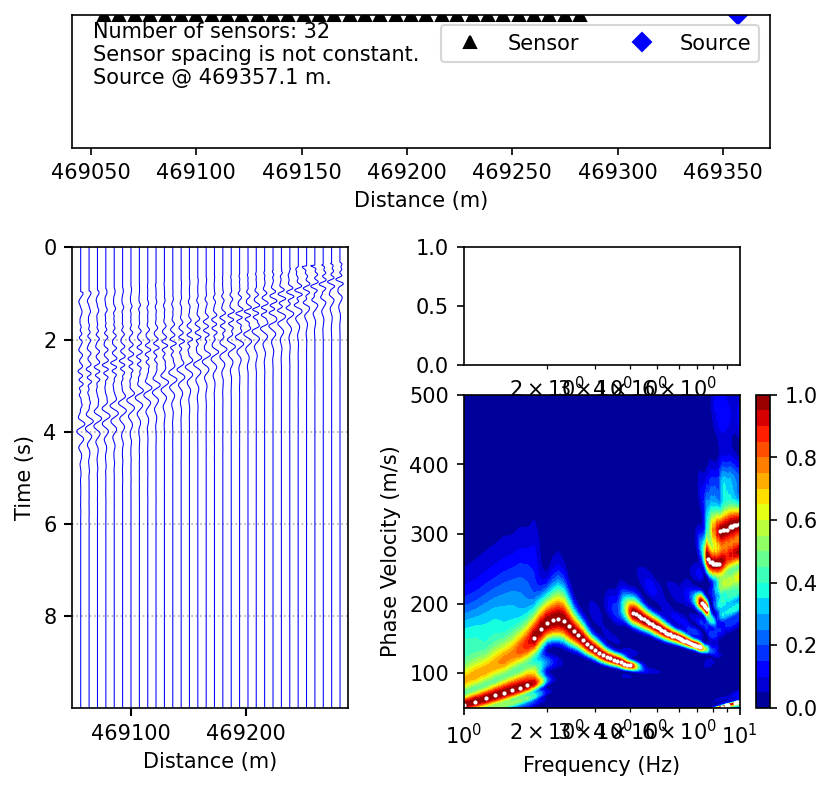

In [24]:
from matplotlib.gridspec import GridSpec
%matplotlib inline
figures = []
fig = plt.figure(figsize=(6,6), dpi=150)

gs = GridSpec(nrows=4, ncols=4, height_ratios=(1.7, 0.5, 1.5, 4), width_ratios=(1, 0.3, 1, 0.05), hspace=0.2, wspace=0.1)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[2:4, 0])
ax2 = fig.add_subplot(gs[2, 2])
ax3 = fig.add_subplot(gs[3, 2])
ax4 = fig.add_subplot(gs[3, 3])

# Array
wavefieldtransform.array.plot(ax=ax0)
ax0.set_yticks([])
ax0.legend(ncol=2)

# Timeseries
wavefieldtransform.array.waterfall(ax=ax1, amplitude_detrend=False, amplitude_normalization="each")
if trim:
    ax1.set_ylim((trim_end, trim_begin))

# Dispersion Image
nearfield = number_of_array_center_distances if display_nearfield else None
wavefieldtransform.plot(fig=fig, ax=ax3, cax=ax4, normalization=wavefield_normalization, nearfield=nearfield)
xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
if display_lambda_res:
    kres_format = dict(linewidth=1.5, color="#000000", linestyle="--")
    kres = wavefieldtransform.array.kres
    kvelocity = 2*np.pi*wavefieldtransform.frequencies / kres
    ax3.plot(wavefieldtransform.frequencies, kvelocity, label=r"$\lambda_{a,min}$" + f"={np.round(2*np.pi/kres,2)} m", **kres_format)
    ax3.legend(loc="upper right")
ax3.set_xlim(xlim)
ax2.set_xlim(xlim)
ax3.set_ylim(ylim)
ax2.set_xscale("log")
ax2.set_xticks([])
ax3.set_xscale("log")

figures.append(fig)
# plt.savefig('../reports/figures/seysmogramm.png')
plt.show()


In [25]:
wavefieldtransform.power

array([[0.88063823, 0.6296646 , 0.50250155, ..., 0.05536435, 0.02021159,
        0.01351819],
       [0.92130642, 0.69160165, 0.50423898, ..., 0.15196882, 0.1214917 ,
        0.05826042],
       [0.95314301, 0.75370185, 0.52386856, ..., 0.25917508, 0.14331526,
        0.15448241],
       ...,
       [0.02363452, 0.02837641, 0.02617965, ..., 0.06831885, 0.06888402,
        0.07211029],
       [0.02368123, 0.02842219, 0.02624097, ..., 0.06648158, 0.06666154,
        0.06985371],
       [0.02372745, 0.02846741, 0.02630174, ..., 0.0646388 , 0.06444682,
        0.06760933]])

In [ ]:
wavefieldtransform = swprocess.Masw.run(fnames="../../data/raw/SGY_10/1.sgy", settings=settings)